#### Custom estimators

In the last unit, we saw how to define our own transformers. In this unit, we will see how to implement custom estimators with the scenario of outliers removal.

#### Use case - outliers removal
Let’s start by loading the dataset.

In [2]:
import pandas as pd

data_df = pd.read_csv("c3_house-prices.csv")
data_df.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


We learned about skewed distributions in the last subject and saw how log-transforms can help in such cases. However, it’s still possible that some values remain far from the mean after the transformation.

For instance, let’s plot the z-scores distribution of the Lot Area variable before and after the log-transform. This time, we use the zscore() function from the scipy.stats module.

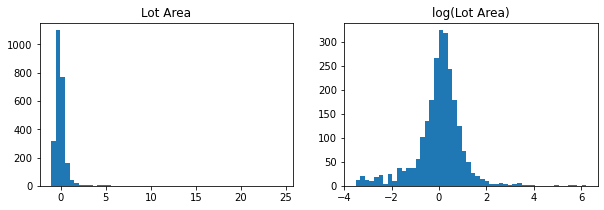

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# Check for outliers in the continuous features
c = "Lot Area"
x = data_df[c].dropna()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax1.hist(zscore(x), bins=50)
ax2.hist(zscore(np.log1p(x)), bins=50)
ax1.set_title(c)
ax2.set_title("log({})".format(c))
plt.show()


We can see that the transformation helps, but there are still many values with a z-score above +3 or below -3. We could simply remove them with Pandas before applying our ML models in Scikit-learn. However, let’s see how to encapsulate this preprocessing step into a Scikit-learn object.

The Lot Area isn’t the only variable with a skewed distribution in this dataset. In the following code, we list them and create the train and test sets.



In [4]:
from sklearn.model_selection import train_test_split

# Create X, y
X = data_df.drop("SalePrice", axis=1)
y = np.log10(data_df.SalePrice)

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

# Continuous variables to check
to_check = ["Lot Area", "Lot Frontage", "Total Bsmt SF", "Gr Liv Area", "Garage Area"]
X_tr[to_check].head()


,Lot Area,Lot Frontage,Total Bsmt SF,Gr Liv Area,Garage Area
339,20896,49.0,2077.0,2097,1134.0
1557,8930,68.0,0.0,1902,539.0
2167,3811,44.0,1594.0,1646,482.0
706,11200,NaN,1298.0,1298,403.0
2396,31250,125.0,0.0,1600,270.0


Note that we still have missing values in the data. In this unit, we ignore them during the outliers removal part and will then see later in this unit how to replace them using a SimpleImputer transformer object.

#### ClassifierMixin object
In the last unit, we defined our own transformers by creating a subclass of the BaseEstimator and TransformerMixin. Similarly, we can define custom estimators by creating a subclass of BaseEstimator and

RegressorMixin for regression tasks
ClassifierMixin for classification ones
Let’s see how to create a ZScoresOutlierClassifier class that takes a set of column names to check for outliers and a removal threshold. This custom estimator will predict whether a point is an outlier or not - since this is a classification task, we need to extend ClassifierMixin.



In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom outliers detector base on z-scores
# Adapted from https://github.com/scikit-learn/scikit-learn/issues/9630#issuecomment-325202441
class ZScoresOutlierClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, columns, threshold=3):
        self.columns = columns
        self.threshold = threshold

    def fit(self, X_df, y):
        # Check that X_df is a DataFrame
        assert type(X_df) == pd.DataFrame

        # Compute train mean/std
        self.train_mean_ = X_df[self.columns].mean()
        self.train_std_ = X_df[self.columns].std()

        # Return estimator
        return self

    def predict(self, X_df):
        # Check that X_df is a DataFrame
        assert type(X_df) == pd.DataFrame

        # Apply threshold
        z_scores = (X_df[self.columns] - self.train_mean_) / (self.train_std_)
        below_threshold = np.abs(z_scores.fillna(0)) <= self.threshold

        # Find inliners
        mask = below_threshold.all(axis=1)

        # Return predictions: +1 for inliners, -1 for outliers
        return mask.replace({True: 1, False: -1})

In this code, we define two functions: fit() and predict().

The fit function computes the mean and standard deviation of each column of the train DataFrame and stores them in the train_mean_ and train_std_ variables. The “predict” part computes the z-scores using simple Pandas code and checks that the data points are below the defined threshold.

Note the Pandas all(axis=1) call - a point that isn’t an outlier should have all its z-scores below the threshold. Finally, we return 1 for normal points and -1 for outliers: this is the standard encoding for outlier detector objects from Scikit-learn.

Let’s test our custom classifier on the training data



In [6]:
outliers_clf = ZScoresOutlierClassifier(to_check)
outliers_clf.fit(X_tr, y_tr)
outliers_clf.predict(X_tr).head()

339    -1
1557    1
2167    1
706     1
2396    1
dtype: int64

As we can see, the first point is labeled as an outlier and shouldn’t be used to train the model.

Challenge: We didn’t check for outliers in the output variable - can you adapt the code to also handle extreme values in the target?

#### RegressorMixin object
Now that we have a custom outlier classifier, let’s see how to use it to improve our predictions. Remember: outliers hurt the performance of our models because of the RSS-based cost functions which have bad statistical properties i.e. they don’t handle well statistically extreme values.

Let’s define a WithoutOutliersRegressor object that first removes the outliers from the training data before fitting the estimator.



In [7]:
from sklearn.base import RegressorMixin, clone

# Custom regressor with an embedded outliers detector
# Adapted from https://github.com/scikit-learn/scikit-learn/issues/9630#issuecomment-325202441
class WithoutOutliersRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, outlier_detector, regressor):
        self.outlier_detector = outlier_detector
        self.regressor = regressor

    def fit(self, X, y, verbose=False):
        # Fit outliers detector, use it on X
        self.outlier_detector_ = clone(self.outlier_detector).fit(X, y)
        outliers = self.outlier_detector_.predict(X) == -1

        # Print the number of outliers detected
        if verbose:
            print(
                "Outliers detected: {} ({:.1f}%)".format(
                    outliers.sum(), 100 * outliers.mean()
                )
            )

        # Fit regressor without the outliers
        self.regressor_ = clone(self.regressor).fit(X[~outliers], y[~outliers])

        # Return the estimator
        return self

    def predict(self, X):
        # Make predictions with the regressor (fitted without the outliers)
        return self.regressor_.predict(X)

Again, we need to define the fit() and predict() functions.

In the fit part, we fit our outlier detector to the training data, create an outliers mask and use it to exclude outliers from our model fit() call. In the “predict” part, we simply use our fitted regressor object to make new predictions for all data points i.e. including potential outliers.

So far in this course, we always saw examples where the current state of our estimators was clear ex. is it fitted, on what data are the coefficients computed and so on. However, in this implementation, we are working with an outlier detector and a regressor that are created outside our custom estimator, and we modify them inside it by calling the .fit() method.

To avoid any confusion, we clone the estimators with the clone() function from Scikit-learn - that way, we are sure to leave the original objects unmodified. This issue is very similar to what can happen with Pandas inplace=True operations. If you’re curious about this, you can take a look at this example which illustrate the issue.

#### Complete pipeline
Let’s use our new estimator in a complete pipeline. First, we need to fill missing values and encode non-numerical variables. This time, we will use the SimpleImputer object from Scikit-learn to handle missing values.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for non-numerical columns
onehot_columns = X.select_dtypes(exclude=np.number).columns
onehot_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

By setting its strategy parameter to most_frequent, the imputer simply replaces missing values with the most frequent value found in the column. Other possible strategies are mean, median and constant. You can always refer to the documentation if you’re unsure about the different options.

Let’s also define the transformations for the numerical columns.



In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

# Basic transformations for the others
other_columns = X.columns.difference(onehot_columns)
other_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("log", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler()),
    ]
)

Again, we perform minimal preprocessing steps. We first impute missing values, apply the log-transform and standardize the results.

Let’s collect the preprocessing steps into a final ColumnTransformer



In [10]:
from sklearn.compose import ColumnTransformer

# Create preprocessor
preprocessor = ColumnTransformer(
    [
        ("onehot", onehot_transformer, onehot_columns),
        ("other", other_transformer, other_columns),
    ]
)

Finally, let’s create our WithoutOutliersRegressor custom estimator. We simply need to pass the outlier detector and the regressor

In [11]:
from sklearn.linear_model import Ridge

# Define pipeline
model = WithoutOutliersRegressor(
    outlier_detector=ZScoresOutlierClassifier(to_check, threshold=3),
    regressor=Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())]),
)

It’s important to note that our ZScoresOutlierClassifier works on the untransformed DataFrame - our preprocessor is only applied before the Ridge model! For this reason, the detector is working on the original variables and not the log-transformed ones.

To apply the outliers detector on the log-transformed variables, we cannot simply encapsulate our detector into a ColumnTransformer that applies the log-transform to the columns listed in to_check. The reason is simple: as we saw in the last units, column transformer objects produce Numpy arrays. However, our outliers detector works on DataFrames!



#### Final evaluation
Let’s see how our fully-encapsulated model performs.



In [12]:
import warnings

warnings.simplefilter("ignore", FutureWarning)

model.fit(X_tr, y_tr, verbose=True)

Outliers detected: 38 (3.1%)


WithoutOutliersRegressor(outlier_detector=ZScoresOutlierClassifier(columns=['Lot '
                                                                            'Area',
                                                                            'Lot '
                                                                            'Frontage',
                                                                            'Total '
                                                                            'Bsmt '
                                                                            'SF',
                                                                            'Gr '
                                                                            'Liv '
                                                                            'Area',
                                                                            'Garage '
                                                                            

The outlier detector labeled around 3% of the entries as outliers. Those training points won’t be used to fit the model.

Let’s evaluate it on the test set.

In [13]:
from sklearn.metrics import mean_absolute_error as MAE

# Evaluate predictions
y_pred = model.predict(X_te)
print("MAE: {:,.2f}$".format(MAE(10 ** y_te, 10 ** y_pred)))

MAE: 14,215.87$


This time, we get an MAE score around 14 thousand dollars which is similar to what we obtained in the previous units.

The advantage of our pipeline is that we can easily switch to other outlier detection methods. It’s not part of the course to know how the different detectors work, but it’s important to know that Scikit-learn implements many advanced techniques that can be used out-of-the-box once we are familiar with the transformers and estimators API.

The library also does a great job at documenting the different approaches. If you google sklearn outlier detection, you should get this page which documents them in the top results.

For instance, let’s try with the IsolationForest detector

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline

# Try with Isolation forests
model2 = WithoutOutliersRegressor(
    outlier_detector=make_pipeline(preprocessor, IsolationForest(random_state=0)),
    regressor=Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())]),
)
model2.fit(X_tr, y_tr, verbose=True)

# Evaluate predictions
y_pred = model2.predict(X_te)
print("MAE: {:,.2f}$".format(MAE(10 ** y_te, 10 ** y_pred)))

Outliers detected: 5 (0.4%)
MAE: 14,480.59$


This time, we add our preprocessor before the IsolationForest using the make_pipeline() function to quickly create a Pipeline without having to name each step.

As we can see, the isolation forest labels 10% of the data points as outliers and we get a slightly larger MAE score.

#### Summary
In this unit, we saw how to create custom estimators with the example of outliers removal. Custom estimators can be particularly useful if we need to encapsulate tools from other libraries into our Scikit-learn workflow. For instance, encapsulate ML methods from NLTK, TensorFlow or even our own algorithms.

In the next unit, we will discuss advanced transformations that can improve the performance of our models. This will end our tour of the Scikit-learn library and machine learning workflow.